## Predicting

**Importing librairies**


In [165]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
import geopandas as gpd


https://medium.com/digital-catapult/dealing-with-imbalanced-data-8b21e6deb6cd

**Importing data**

In [166]:
filename_1 = "../data/_tarefelt1.csv"

In [167]:
data_1 = pd.read_csv(filename_1)
X = data_1

**Unbalanced**

In [168]:
X_sampled = X.drop(X[X['label'] == 0].sample(frac=.90).index)

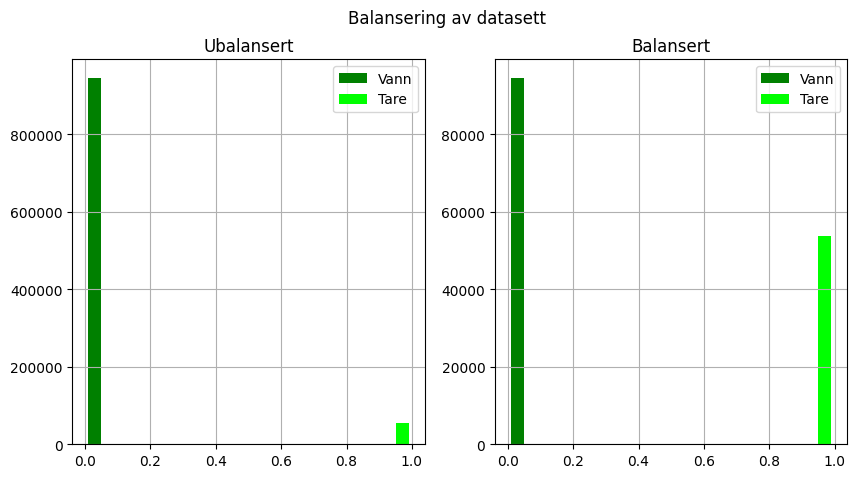

In [169]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
fig.suptitle("Balansering av datasett")

ax1.hist([X[X['label'] == 0].label, X[X['label'] == 1].label],  color = ["green", "lime"], label = ["Vann", "Tare"])
ax1.set_title("Ubalansert")
ax1.legend()
ax1.grid()

ax2.hist([X_sampled[X_sampled['label'] == 0].label, X_sampled[X_sampled['label'] == 1].label],  color = ["green", "lime"], label = ["Vann", "Tare"])
ax2.set_title("Balansert")
ax2.legend()
ax2.grid()

In [170]:
X = X_sampled


In [171]:
X.drop(columns = "Unnamed: 0",  inplace = True)

**Feature Selection**

In [172]:
X.drop(columns = ['band_0', 'band_1', 'band_2'], inplace = True)

**Splitting data**

Creating balanced datasets using stratified shuffle split

In [174]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X, X.label)):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]


**Feature extracting**

In [175]:
y_train = X_train.label
X_train.drop(columns = ['lat','lon', 'geometry', 'label'], inplace = True)

In [176]:
lat = X_test.lat
lon = X_test.lon
y_test = X_test.label
X_test.drop(columns = ['lat','lon', 'geometry', 'label'], inplace = True)

**Standarscaling**


In [177]:
scaler = StandardScaler()
scaler.fit(X_train) 
scaled_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(scaled_X_train, index= X_train.index, columns=X_train.columns)
scaled_X_test = scaler.transform(X_test)
X_test  = pd.DataFrame(scaled_X_test, index= X_test.index, columns=X_test.columns)

**Training the model**  


In [194]:
def batch(iterable_X, iterable_y, n=1):
    '''
    n: batchsize
    '''
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]


**Predicting using partial fit**

In [196]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(loss = "log_loss",  
                    verbose = 50, 
                    warm_start = True, 
                    penalty = "elasticnet", 
                    class_weight= dict(zip(np.unique(y_train), class_weights)))

classes = np.unique(y_train)
accuracy =[]

ROUNDS = 100
batchsize = 1000

#Velger testsize så liten som mulig. Fordi den brukes ikke til noe.
sss = StratifiedShuffleSplit(n_splits=ROUNDS, test_size=0.005, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X_train, y_train)):

    X_sgd = X_train.iloc[train_index]
    y_sgd = y_train.iloc[train_index]

    X_val = X_train.iloc[test_index]
    y_val = y_train.iloc[test_index]

    batcherator= batch(X_sgd, y_sgd, batchsize)
    for index, (x_batch, y_batch) in enumerate(batcherator):
        clf.partial_fit(x_batch, y_batch, classes)
        y_predicted = clf.predict(X_val)
        accuracy.append(log_loss(y_val, y_predicted))

-- Epoch 1
Norm: 182.64, NNZs: 63, Bias: 59.826271, T: 1000, Avg. loss: 101.195749
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 134.10, NNZs: 63, Bias: 12.890727, T: 1000, Avg. loss: 52.481122
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 83.55, NNZs: 63, Bias: -10.117904, T: 1000, Avg. loss: 31.146797
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 79.39, NNZs: 62, Bias: 6.721236, T: 1000, Avg. loss: 23.590554
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 56.97, NNZs: 63, Bias: 4.866733, T: 1000, Avg. loss: 39.116744
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 48.81, NNZs: 61, Bias: 3.252822, T: 1000, Avg. loss: 19.964803
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 49.57, NNZs: 63, Bias: -8.197333, T: 1000, Avg. loss: 26.634939
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 50.45, NNZs: 63, Bias: 5.398589, T: 1000, Avg. loss: 12.657065
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 46.54, NNZs: 63, Bias: -10.086134, T: 1000, Avg. loss: 

**Evaluating Model**


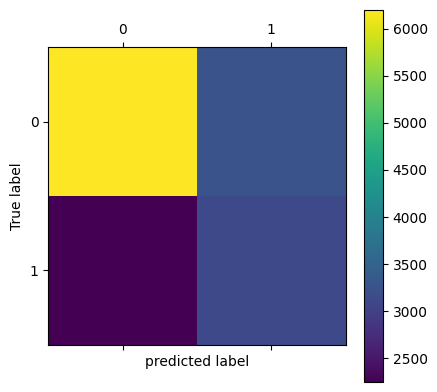

In [197]:
y_predicted = clf.predict(X_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)
# Plot matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

**Sjekke accuracy**

In [182]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(loss='huber',  
                    warm_start = False, 
                    penalty = "l2",
                    class_weight= dict(zip(np.unique(y_train), class_weights)), 
                    learning_rate = "optimal",
                    alpha = 0.001
                    )

NROUNDS = 100
skf = StratifiedKFold(shuffle=True, n_splits=NROUNDS)
cv_results_skfold_hinge = cross_val_score(clf, X_train, y_train, cv=skf, scoring='accuracy')

In [183]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(loss='huber', 
                    warm_start = True, 
                    penalty = "l2",
                    learning_rate = "optimal",
                    alpha = 0.001
                    )
NROUNDS = 100
skf = StratifiedKFold(shuffle=True, n_splits=NROUNDS)
cv_results_skfold_log_loss = cross_val_score(clf, X_train, y_train, cv=skf, scoring='accuracy')

**Plotting accuracy**

Text(0.5, 0.98, 'Sammenligner med og uten vekter.')

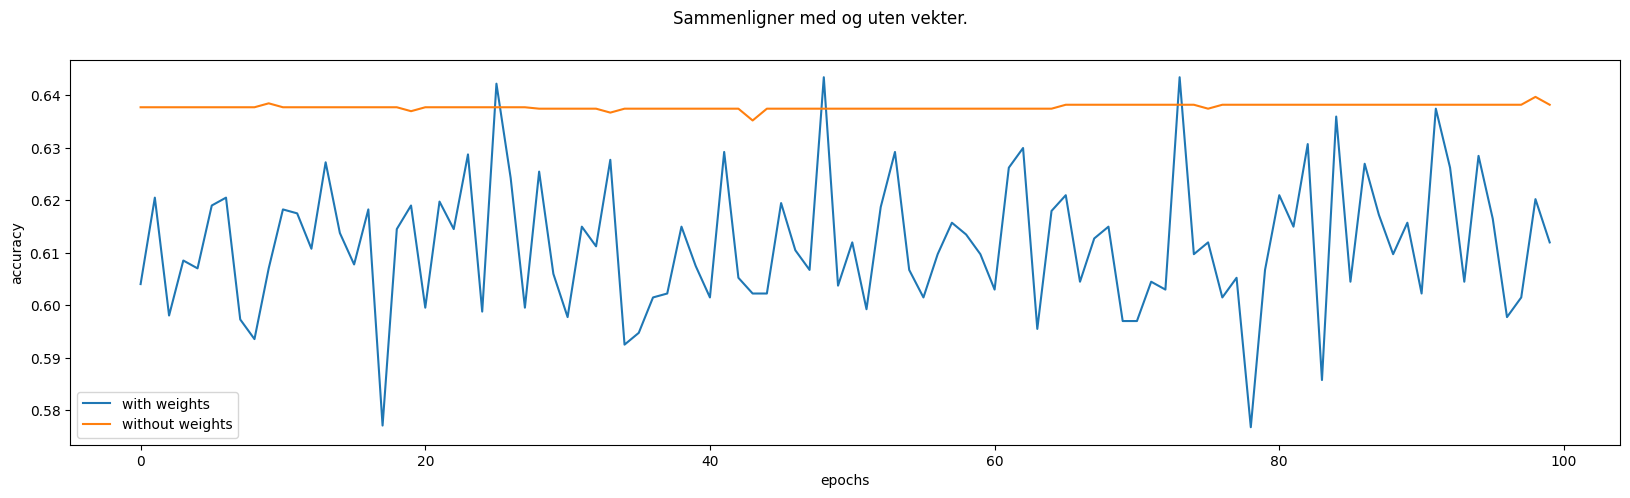

In [184]:
fig, ax1 = plt.subplots(1, figsize = (20,5))
ax1.plot(cv_results_skfold_hinge, label ="with weights")
ax1.plot(cv_results_skfold_log_loss ,label = "without weights")
ax1.legend()
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
fig.suptitle("Sammenligner med og uten vekter.")

In [214]:
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(),SGDClassifier(loss = "modified_huber",  
                    warm_start = False, 
                    penalty = "l2", 
                    class_weight= dict(zip(np.unique(y_train), class_weights))))
clf.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(class_weight={0.0: 0.7839554736211735,
                                             1.0: 1.3804197250077535},
                               loss='modified_huber'))])

**Plotting accuracy**

**Evaluating Model**


**Plotting the predicted seaweed and comparing with naturdirektoratet**

In [192]:
y_predicted = clf.predict(X_test)

X_final = X_test.copy()
X_final["label"] = y_test
X_final["y_predicted"] = y_predicted
X_final = gpd.GeoDataFrame(X_final, geometry=gpd.points_from_xy(lon, lat))

df_no_seaweed = X_final[X_final["y_predicted"] == 0].copy()
df_seaweed = X_final[X_final["y_predicted"] == 1].copy()
df_true_seaweed = X_final[X_final["label"] == True].copy()

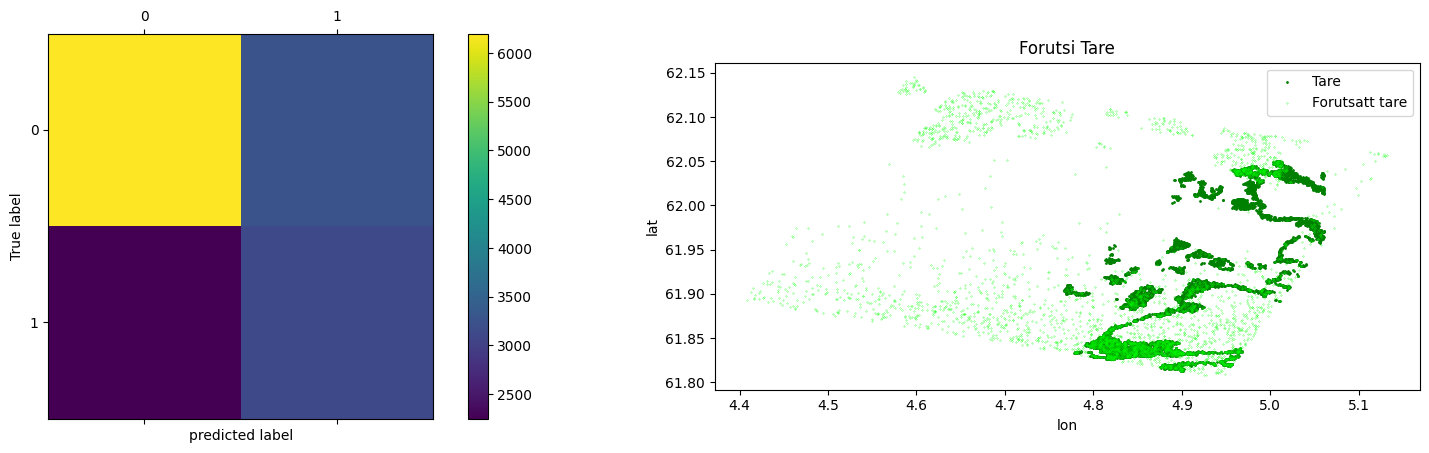

In [213]:
fig, (ax1, ax2) = plt.subplots(1,2 ,figsize = (20,5))


conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)

im = ax1.matshow(conf_mat)
ax1.set_ylabel("True label")
ax1.set_xlabel("predicted label")

df_true_seaweed.plot(ax = ax2, color = "green", label = "Tare", markersize = 1)
df_seaweed.plot(ax = ax2, color = "lime", label = "Forutsatt tare", markersize = 0.05)

ax2.set_title("Forutsi Tare")
ax2.set_xlabel("lon")
ax2.set_ylabel("lat")
fig.colorbar(im)

